# Structuring The Dataset

In [1]:
from PIL import Image
import numpy as np
import os
import cv2
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [2]:
data=[]

parasitized=os.listdir("C:/Users/Acer/Documents/MMD/Code/Dataset/cell_images/Parasitized/")
for par in parasitized:
    try:
        image=cv2.imread("C:/Users/Acer/Documents/MMD/Code/Dataset/cell_images/Parasitized/" + par)
        image_from_array = Image.fromarray(image, 'RGB')
        size_image = image_from_array.resize((100, 100))
        data.append(np.array(size_image))
    except AttributeError:
        print("Skipped one in parasitized")

uninfected=os.listdir("C:/Users/Acer/Documents/MMD/Code/Dataset/cell_images/Uninfected/")
for uninfec in uninfected:
    try:
        image=cv2.imread("C:/Users/Acer/Documents/MMD/Code/Dataset/cell_images/Uninfected/" + uninfec)
        image_from_array = Image.fromarray(image, 'RGB')
        size_image = image_from_array.resize((100, 100))
        data.append(np.array(size_image))
    except AttributeError:
        print("Skipped one in uninfected")

labels = np.concatenate((np.zeros(len(parasitized)), np.ones(len(uninfected))), axis=0)

cells = np.array(data)

Skipped one in parasitized
Skipped one in uninfected


In [3]:
# verifying lengths
print(f'len(parasitized):\t{len(parasitized)}')
print(f'len(uninfected):\t{len(uninfected)}')
print(f'len(cells):\t\t{len(cells)}')
print(f'len(data):\t\t{len(data)}')

len(parasitized):	13773
len(uninfected):	13773
len(cells):		27544
len(data):		27544


In [4]:
# shuffling data to get ready for split
shuffle = np.arange(cells.shape[0])
np.random.shuffle(shuffle)
cells = cells[shuffle]
labels = labels[shuffle]

In [5]:
# splitting data into train, test and validation sets (manually)
x_train, x_test, x_val = cells[:25000], cells[25000:27500], cells[27500:]
y_train, y_test, y_val = labels[:25000], labels[25000:27500], labels[27500:]

In [6]:
# verifying even distribution of data
print("\t0's\t1's")
print(f'y_train\t{np.count_nonzero(y_train == 0)}\t{np.count_nonzero(y_train == 1)}')
print(f'y_test\t{np.count_nonzero(y_test == 0)}\t{np.count_nonzero(y_test == 1)}')
print(f'y_val\t{np.count_nonzero(y_val == 0)}\t{np.count_nonzero(y_val == 1)}')

	0's	1's
y_train	12494	12506
y_test	1257	1243
y_val	22	22


# Training The Model

In [7]:
# data augmentation to reduce variance
datagen = ImageDataGenerator(
        rotation_range = 30,    # rotate images in the range 30 degrees
        zoom_range = 0.2,       # zoom image
        width_shift_range=0.1,  # shift images horizontally (fraction of total width)
        height_shift_range=0.1, # shift images vertically (fraction of total height)
        horizontal_flip = True, # flip images
        )

In [8]:
# dense layer 1 and 2 have 512 neurons instead of 4096 neurons in the standard AlexNet architecture,
# due to low availible input size of images --> 100, 100, 3 (recommended size for AlexNet --> 227, 227, 3)

alexnet = tf.keras.models.Sequential([
    # convolution 1
    Conv2D(96, (11,11),strides=(4,4), activation='relu', input_shape=(100, 100, 3)),
    BatchNormalization(),
    MaxPooling2D(),
    # convolution 2
    Conv2D(256, (5,5),strides=(1,1), activation='relu',padding="same"),
    BatchNormalization(),
    MaxPooling2D(),
    # convolution 3
    Conv2D(384, (3,3),strides=(1,1), activation='relu',padding="same"),
    BatchNormalization(),
    # convolution 4
    Conv2D(384, (3,3),strides=(1,1), activation='relu',padding="same"),
    BatchNormalization(),
    # convolution 5
    Conv2D(256, (3, 3), strides=(1, 1), activation='relu',padding="same"),
    BatchNormalization(),
    MaxPooling2D(),
    # flattening
    Flatten(),
    # dense layer 1
    Dense(512, activation='relu'),
    Dropout(0.5),
    # dense layer 2
    Dense(512, activation='relu'),
    Dropout(0.5),
    # output neuron
    Dense(1, activation='sigmoid')
])

alexnet.summary()

C:\Users\Acer\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 23, 23, 96)     │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 23, 23, 96)     │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 11, 11, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 256)    │       614,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 11, 11, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 5, 5, 384)      │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 5, 5, 384)      │         1,536 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 5, 5, 384)      │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 5, 5, 384)      │         1,536 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 5, 5, 256)      │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 5, 5, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,540,673 (17.32 MB)

 Trainable params: 4,537,921 (17.31 MB)

 Non-trainable params: 2,752 (10.75 KB)

In [9]:
alexnet.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

In [10]:
# training the model
history = alexnet.fit(
    datagen.flow(x_train, y_train, batch_size = 64),
    epochs = 12,
    validation_data = datagen.flow(x_val, y_val)
    )

C:\Users\Acer\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/12
391/391 ━━━━━━━━━━━━━━━━━━━━ 117s 292ms/step - accuracy: 0.5878 - loss: 0.8495 - val_accuracy: 0.5000 - val_loss: 4.6377
Epoch 2/12
391/391 ━━━━━━━━━━━━━━━━━━━━ 113s 290ms/step - accuracy: 0.7109 - loss: 0.5736 - val_accuracy: 0.7500 - val_loss: 0.5528
Epoch 3/12
391/391 ━━━━━━━━━━━━━━━━━━━━ 123s 314ms/step - accuracy: 0.8928 - loss: 0.2919 - val_accuracy: 0.9545 - val_loss: 0.1656
Epoch 4/12
391/391 ━━━━━━━━━━━━━━━━━━━━ 113s 290ms/step - accuracy: 0.9127 - loss: 0.2611 - val_accuracy: 0.9091 - val_loss: 0.2565
Epoch 5/12
391/391 ━━━━━━━━━━━━━━━━━━━━ 121s 309ms/step - accuracy: 0.9241 - loss: 0.2305 - val_accuracy: 0.8864 - val_loss: 0.2553
Epoch 6/12
391/391 ━━━━━━━━━━━━━━━━━━━━ 112s 287ms/step - accuracy: 0.9238 - loss: 0.2247 - val_accuracy: 0.8864 - val_loss: 0.2788
Epoch 7/12
391/391 ━━━━━━━━━━━━━━━━━━━━ 116s 296ms/step - accuracy: 0.9294 - loss: 0.2090 - val_accuracy: 0.9318 - val_loss: 0.2238
Epoch 8/12
391/391 ━━━━━━━━━━━━━━━━━━━━ 113s 289ms/step - accuracy: 0.9294 -

# Trends in Training

In [11]:
print(f"Loss : {alexnet.evaluate(x_test,y_test)[0]}")
print(f"Accuracy % : {alexnet.evaluate(x_test,y_test)[1]*100}")

79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - accuracy: 0.9594 - loss: 0.2127
Loss : 0.21397316455841064
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - accuracy: 0.9594 - loss: 0.2127
Accuracy % : 95.59999704360962


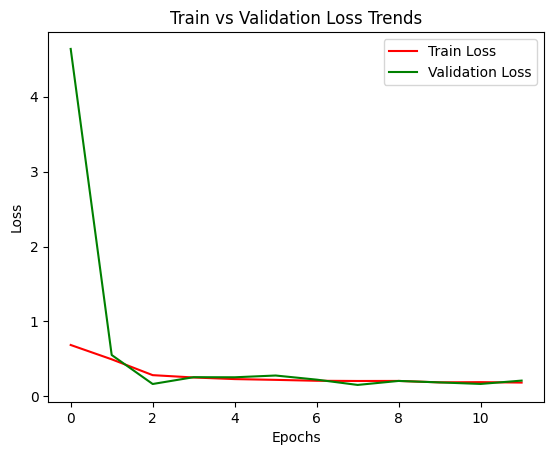

In [12]:
# train and validation loss trends
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = [i for i in range(0, 12)]
plt.plot(epochs, train_loss, 'r', label='Train Loss')
plt.plot(epochs, val_loss, 'g', label='Validation Loss')
plt.title('Train vs Validation Loss Trends')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

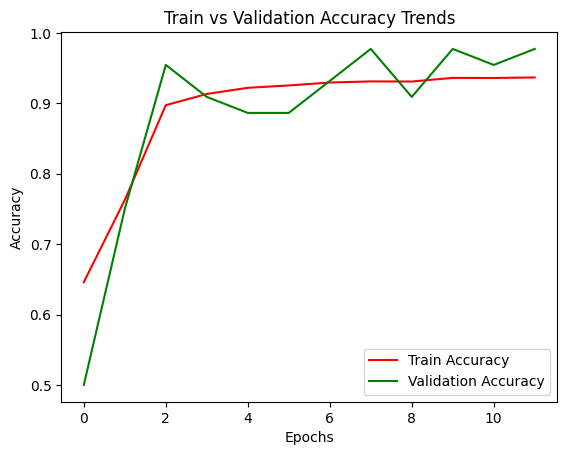

In [13]:
# train and validation Accuracy trends
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = [i for i in range(0, 12)]
plt.plot(epochs, train_accuracy, 'r', label='Train Accuracy')
plt.plot(epochs, val_accuracy, 'g', label='Validation Accuracy')
plt.title('Train vs Validation Accuracy Trends')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Results

## Test Set

In [20]:
preds = alexnet.predict(x_test)
print(preds.shape)  # Should be either (num_samples, num_classes) or (num_samples,)

79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step
(2500, 1)


In [21]:
preds = alexnet.predict(x_test)
predictions = (preds > 0.5).astype(int).flatten()

# confusion matrix
print('Confusion Matrix:\n', confusion_matrix(y_test, predictions), sep='')
print(f'Accuracy Score: {accuracy_score(y_test, predictions)*100}%')

79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step
Confusion Matrix:
[[1202   55]
 [  55 1188]]
Accuracy Score: 95.6%


In [22]:
# detailed stats on models performance
print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.96      0.96      0.96      1257
   Normal (Class 1)       0.96      0.96      0.96      1243

           accuracy                           0.96      2500
          macro avg       0.96      0.96      0.96      2500
       weighted avg       0.96      0.96      0.96      2500



## Train Set

In [23]:
preds = alexnet.predict(x_train)
predictions = (preds > 0.5).astype(int).flatten()

# confusion matrix
print('Confusion Matrix:\n', confusion_matrix(y_train, predictions), sep='')
print(f'Accuracy Score: {accuracy_score(y_train, predictions)*100}%')

782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 52ms/step
Confusion Matrix:
[[12005   489]
 [  691 11815]]
Accuracy Score: 95.28%


In [24]:
# detailed stats on models performance
print(classification_report(y_train, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.95      0.96      0.95     12494
   Normal (Class 1)       0.96      0.94      0.95     12506

           accuracy                           0.95     25000
          macro avg       0.95      0.95      0.95     25000
       weighted avg       0.95      0.95      0.95     25000



# Saving The Model

In [25]:
alexnet.save('./alexnet.h5', save_format='h5')

In [4]:
# verifying saved model
model = tf.keras.models.load_model('./alexnet.h5')
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 23, 23, 96)     │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 23, 23, 96)     │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 11, 11, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 256)    │       614,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 11, 11, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 5, 5, 384)      │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 5, 5, 384)      │         1,536 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 5, 5, 384)      │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 5, 5, 384)      │         1,536 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 5, 5, 256)      │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 5, 5, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,540,675 (17.32 MB)

 Trainable params: 4,537,921 (17.31 MB)

 Non-trainable params: 2,752 (10.75 KB)

 Optimizer params: 2 (12.00 B)

In [1]:

from tensorflow.keras.preprocessing import image
from PIL import Image

def preprocess_image(img_path, target_size):
    """
    Load and preprocess the image for the model.
    """
    # Load the image using PIL
    img = Image.open(img_path)
    
    # Resize the image to the target size expected by the model
    img = img.resize(target_size)
    
    # Convert the image to a numpy array
    img_array = image.img_to_array(img)
    
    # Add a batch dimension (CNN models expect inputs in batches)
    img_array = np.expand_dims(img_array, axis=0)
    
    return img_array

In [4]:
# Parasitized

img_dir = 'C:/Users/Acer/Documents/MMD/Code_2/holdout dataset/Parasitized/'

 # Preprocess the image
target_size = (100, 100)  # Example: replace with your model's input size

# Process and predict multiple images
for img_file in os.listdir(img_dir):
    img_path = os.path.join(img_dir, img_file)
    processed_image = preprocess_image(img_path, target_size)
    predictions = model.predict(processed_image)
    
    # Interpret the output
    if predictions.shape[1] > 1:  # Multi-class classification
        predicted_class = np.argmax(predictions, axis=1)[0]
    else:  # Binary classification
        predicted_class = (predictions > 0.5).astype(int)[0][0]
    
    # Display "paratized" instead of 0
    if predicted_class == 0:
        result = "Paratized"
    else:
        result = "Uninfected"
        
    print(f"Image: {img_file}, Predicted Class: {result}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
Image: C39P4thinF_original_IMG_20150622_110115_cell_121.png, Predicted Class: Paratized
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Image: C39P4thinF_original_IMG_20150622_113126_cell_6.png, Predicted Class: Paratized
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Image: C39P4thinF_original_IMG_20150622_113446_cell_1.png, Predicted Class: Paratized
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Image: C39P4thinF_original_IMG_20150622_113446_cell_29.png, Predicted Class: Paratized
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Image: C98P59ThinF_IMG_20150917_153030_cell_159.png, Predicted Class: Paratized
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Image: C98P59ThinF_IMG_20150917_153311_cell_162.png, Predicted Class: Paratized
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Image: C98P59ThinF_IMG_20150917_154452_cell_205.png, Predicted Class: Paratized


In [11]:
# Uninfected

img_dir = 'C:/Users/Acer/Documents/MMD/Code_2/holdout dataset/Uninfected/'

 # Preprocess the image
target_size = (100, 100)  # Example: replace with your model's input size

# Process and predict multiple images
for img_file in os.listdir(img_dir):
    img_path = os.path.join(img_dir, img_file)
    predictions = model.predict(processed_image)
    
    # Interpret the output
    if predictions.shape[1] > 1:  # Multi-class classification
        predicted_class = np.argmax(predictions, axis=1)[0]
    else:  # Binary classification
        predicted_class = (predictions > 0.5).astype(int)[0][0]
    
    # Display "paratized" instead of 0
    if predicted_class == 0:
        result = "Paratized"
    else:
        result = "Uninfected"
        
    print(f"Image: {img_file}, Predicted Class: {result}")

NameError: name 'processed_image' is not defined

In [10]:
# Paths to dataset
infected_dir = "C:/Users/Acer/Documents/MMD/Code_2/holdout dataset/Parasitized/"
uninfected_dir = "C:/Users/Acer/Documents/MMD/Code_2/holdout dataset/Uninfected/"

# Get 5 images from each class
infected_images = [os.path.join(infected_dir, img) for img in os.listdir(infected_dir)[:5]]
uninfected_images = [os.path.join(uninfected_dir, img) for img in os.listdir(uninfected_dir)[:5]]

# Combine image paths and assign actual labels
image_paths = infected_images + uninfected_images
true_labels = ["Infected"] * len(infected_images) + ["Uninfected"] * len(uninfected_images)

# Image size
target_size = (100, 100)  # Match the training input size

# Convert images to numpy array
image_data = np.array([preprocess_image(img, target_size) for img in image_paths])

image_data = preprocess_image(image_paths, target_size)

# Predict using the model
preds = model.predict(image_data)

# Fix class label mapping based on training order
predictions = np.argmax(preds, axis=1)  # Get the index of the highest probability
class_names = {0: "Uninfected", 1: "Infected"}  # Check train_generator.class_indices to confirm

# Convert predictions to labels
predicted_labels = [class_names[p] for p in predictions]

# Display results
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
axes = axes.ravel()

for i in range(len(image_paths)):
    img = cv2.imread(image_paths[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert color format
    axes[i].imshow(img)
    axes[i].set_title(f"Pred: {predicted_labels[i]}\nActual: {true_labels[i]}")
    axes[i].axis('off')

plt.show()


AttributeError: 'list' object has no attribute 'read'